In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.2.0


# Call API

In [2]:
import requests
r = requests.get('https://api.ipify.org?format=json')
j = r.json()
print(j)

{'ip': '35.198.202.173'}


In [0]:
# More imports
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load Data

In [4]:
# Load in the data
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test  = x_test / 255.0
print("x_train.shape:", x_train.shape)
print("x_test.shape:", x_test.shape)

x_train.shape: (60000, 28, 28)
x_test.shape: (10000, 28, 28)


In [5]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape)

(60000, 28, 28, 1)


In [6]:
K = len(set(y_train))
print("number of classes: ", K)

number of classes:  10


# Build Model

In [7]:
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              epochs = 15)

Epoch 1/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5210 - accuracy: 0.8063 - val_loss: 0.4018 - val_accuracy: 0.8498
Epoch 2/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3612 - accuracy: 0.8641 - val_loss: 0.3461 - val_accuracy: 0.8743
Epoch 3/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3096 - accuracy: 0.8838 - val_loss: 0.3096 - val_accuracy: 0.8845
Epoch 4/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2759 - accuracy: 0.8967 - val_loss: 0.3031 - val_accuracy: 0.8902
Epoch 5/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2526 - accuracy: 0.9051 - val_loss: 0.3161 - val_accuracy: 0.8856
Epoch 6/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2316 - accuracy: 0.9134 - val_loss: 0.3024 - val_accuracy: 0.8927
Epoch 7/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2110 - accuracy: 0.9193 - val_loss: 0.3121 - val_accuracy:

# Save Model

In [9]:
# Save model to temporary file
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, clearning up\n')
  !rm -r {export_path}

tf.saved_model.save(model, export_path)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 168
drwxr-xr-x 2 root root   4096 May 18 20:46 assets
-rw-r--r-- 1 root root 161709 May 18 20:46 saved_model.pb
drwxr-xr-x 2 root root   4096 May 18 20:46 variables


In [10]:
!saved_model_cli show --dir {export_path} --all # print out information of our model


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0518 20:46:46.544845 140678555199360 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/re

# Get Tensorflow Serving

In [11]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   6370      0 --:--:-- --:--:-- --:--:--  6370
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 Packages [354 B]
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:8 http://storage.googleapis.com/tensorflow-servin

In [12]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 46 not upgraded.
Need to get 175 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.1.0 [175 MB]
Fetched 175 MB in 5s (32.2 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.1.0_all.deb ...
Unpacking tensorflow-model-server (2.1.0) ...
Setting up tensorflow-model-server (2.1.0) ...


In [0]:
os.environ["MODEL_DIR"] = MODEL_DIR # Set MODEL_DIR environment variable

In [14]:
# Start up server
# nohup means ignore these signals to shut down
# output of program written to file called server.log
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [15]:
!tail server.log

2020-05-18 20:47:16.690439: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-05-18 20:47:16.706503: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:203] Restoring SavedModel bundle.
2020-05-18 20:47:16.740558: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:152] Running initialization op on SavedModel bundle at path: /tmp/1
2020-05-18 20:47:16.746939: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:333] SavedModel load for tags { serve }; Status: success: OK. Took 58674 microseconds.
2020-05-18 20:47:16.747794: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2020-05-18 20:47:16.747898: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: fashion_model version: 1}
2020-05-18 20:47

In [0]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

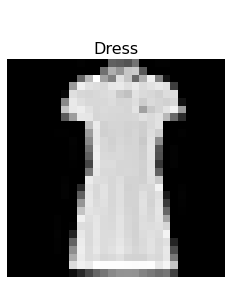

In [17]:
def show(idx, title):
  plt.figure()
  plt.imshow(x_test[idx].reshape(28,28), cmap='gray')
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

i = np.random.randint(0, len(x_test))
show(i, labels[y_test[i]])

# Format Data to Pass to Server

In [18]:
"""
{
  "signature_name": "serving_default",
  "instances": [ an N x H x W x C list ],
}
"""

import json
data = json.dumps({"signature_name": "serving_default", "instances": x_test[0:3].tolist()})
print(data)

{"signature_name": "serving_default", "instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], 

# Save Model

In [19]:
headers = {"content-type": "application/json"}
r = requests.post("http://localhost:8501/v1/models/fashion_model:predict", data=data, headers=headers)
j = r.json()
print(j.keys())
print(j)

dict_keys(['predictions'])
{'predictions': [[1.54902237e-11, 6.29620215e-15, 5.09110644e-14, 1.19450333e-15, 1.36686977e-14, 1.56873163e-08, 1.27678178e-15, 1.27314664e-07, 1.67686709e-12, 0.999999881], [7.93275934e-09, 3.24062392e-13, 0.999941587, 1.53629594e-06, 5.68519e-05, 1.04407941e-11, 4.9264294e-08, 5.71273823e-13, 3.01502018e-10, 1.14430167e-12], [1.04724283e-24, 1.0, 3.39550447e-26, 5.32815549e-28, 6.29611651e-27, 4.42964034e-32, 8.21735181e-28, 2.04298805e-36, 2.1050838e-28, 1.50913773e-35]]}


# Check Model

In [20]:
# Check shapes
pred = np.array(j['predictions'])
print(pred.shape) 
# Size is 3 x 10 = N x K
# pred[N, K] = probability that N'th sample belongs to K'th class

(3, 10)


In [21]:
# Get predicted classes
pred = pred.argmax(axis=1)
pred

array([9, 2, 1])

In [22]:
# Map them back to strings
pred = [labels[i] for i in pred]
print(pred)

['Ankle boot', 'Pullover', 'Trouser']


In [23]:
# Get true labels
actual = [labels[i] for i in y_test[:3]]
print(actual)

['Ankle boot', 'Pullover', 'Trouser']


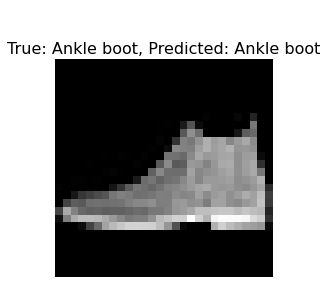

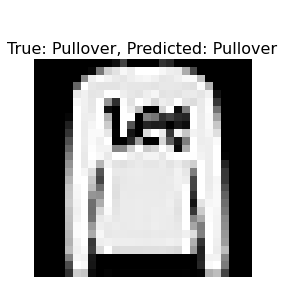

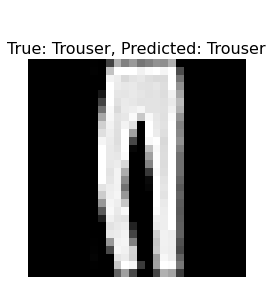

In [24]:
for i in range(3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

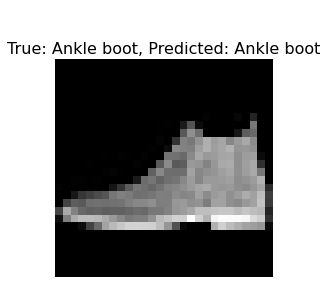

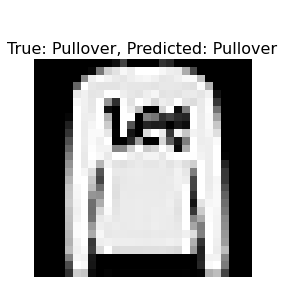

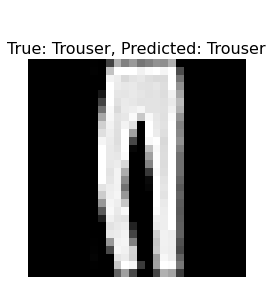

In [25]:
# Allows you to select a model by version

headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
j = r.json()
pred = np.array(j['predictions'])
pred = pred.argmax(axis=1)
pred = [labels[i] for i in pred]
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

# Serve 2 Models

## Build Model

In [26]:
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
x = Flatten()(x)
x = Dense(K, activation='softmax')(x)

model2 = Model(i, x)
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        320       
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [27]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

Epoch 1/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4764 - accuracy: 0.8333 - val_loss: 0.3924 - val_accuracy: 0.8570
Epoch 2/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3365 - accuracy: 0.8800 - val_loss: 0.3458 - val_accuracy: 0.8779
Epoch 3/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2982 - accuracy: 0.8926 - val_loss: 0.3303 - val_accuracy: 0.8811
Epoch 4/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2756 - accuracy: 0.9008 - val_loss: 0.3171 - val_accuracy: 0.8857
Epoch 5/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2584 - accuracy: 0.9071 - val_loss: 0.3075 - val_accuracy: 0.8904
Epoch 6/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2445 - accuracy: 0.9112 - val_loss: 0.3179 - val_accuracy: 0.8870
Epoch 7/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2320 - accuracy: 0.9178 - val_loss: 0.3065 - val_accuracy:

## Save 2nd Model

In [28]:
version = 2
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, clearning up\n')
  !rm -r {export_path}

tf.saved_model.save(model2, export_path)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/2

INFO:tensorflow:Assets written to: /tmp/2/assets

Saved model:
total 84
drwxr-xr-x 2 root root  4096 May 18 20:51 assets
-rw-r--r-- 1 root root 77313 May 18 20:51 saved_model.pb
drwxr-xr-x 2 root root  4096 May 18 20:51 variables


## Check 2nd Model

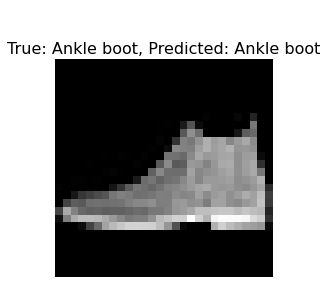

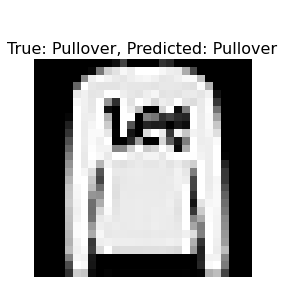

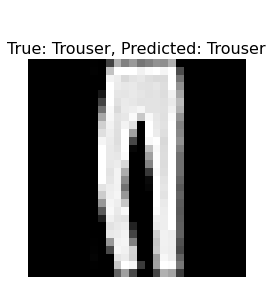

In [30]:
# Allows you to select a model by version

headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/2:predict', data=data, headers=headers)
j = r.json()
pred = np.array(j['predictions'])
pred = pred.argmax(axis=1)
pred = [labels[i] for i in pred]
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

# Check Model That Doesn't Exist

In [32]:
headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/3:predict', data=data, headers=headers)
j = r.json()
print(j.keys())
print(j)

dict_keys(['error'])
{'error': 'Servable not found for request: Specific(fashion_model, 3)'}
